In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

/usr/local/lib64/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Data set on graduate school admissions
df = pd.read_csv('admissions.csv')
df.head()
# Prestige - nebulous measurement of the prestige of the (undergrad) school (1-4)
# Every 100 in USNWR top schools is a ranking number (1 is 1-100)

,admit,gre,gpa,prestige
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [4]:
# Want to predict the ability to get into a grad school given gre, gpa, and school prestige
df.describe()

,admit,gre,gpa,prestige
count,399.000000,399.000000,399.000000,399.000000
mean,0.318296,587.568922,3.390075,2.486216
std,0.466400,115.866214,0.380535,0.945333
min,0.000000,220.000000,2.260000,1.000000
25%,0.000000,520.000000,3.130000,2.000000
50%,0.000000,580.000000,3.390000,2.000000
75%,1.000000,660.000000,3.670000,3.000000
max,1.000000,800.000000,4.000000,4.000000


In [5]:
# Cross tabulate admit with prestige
pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])
# People don't apply evenly, technically higher odds to get into a good school
# Grad school admission is not objective

prestige,1,2,3,4
admit,,,,
0,28,96,93,55
1,33,54,28,12


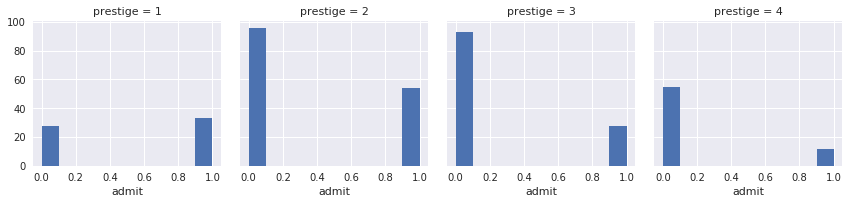

In [6]:
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

# Plot small multiples of prestige vs admit
multiples = sns.FacetGrid(df, col='prestige')
multiples = multiples.map(plt.hist, 'admit')

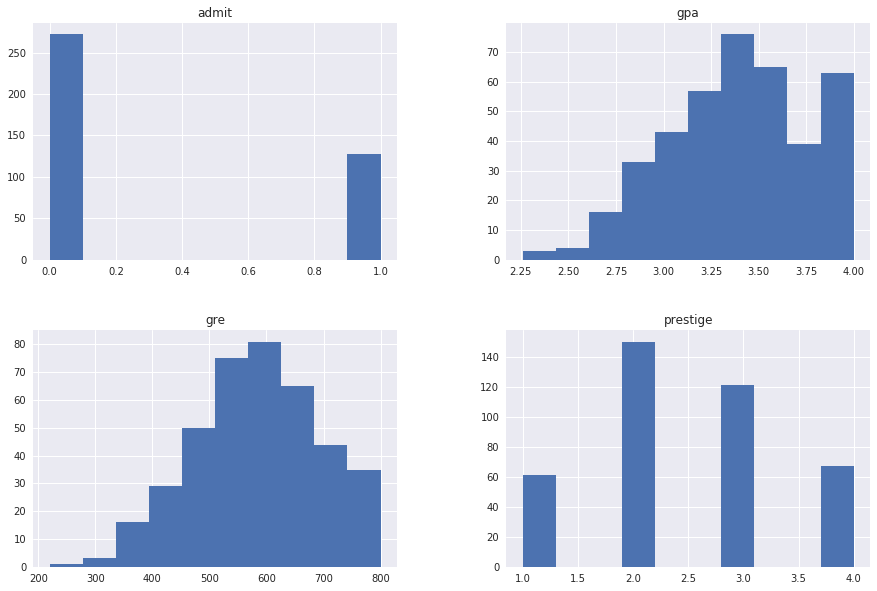

In [8]:
# Show histograms of all columns
df.hist(figsize=(15,10))
plt.show()

In [12]:
# Dummify prestige, dummy variable used to sort categorical variables into mutually exclusive categroies
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
dummy_ranks.head()

,prestige_1,prestige_2,prestige_3,prestige_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [16]:
# Keep all columns besides prestige which is replaced with the dummy variables
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.loc[:, 'prestige_2':])
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4
0,0,380,3.61,0,1,0
1,1,660,3.67,0,1,0
2,1,800,4.00,0,0,0
3,1,640,3.19,0,0,1
4,0,520,2.93,0,0,1


In [18]:
data['intercept'] = 1.0
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
0,0,380,3.61,0,1,0,1.0
1,1,660,3.67,0,1,0,1.0
2,1,800,4.00,0,0,0,1.0
3,1,640,3.19,0,0,1,1.0
4,0,520,2.93,0,0,1,1.0


In [29]:
# Bug work-around for result.summary() below
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [30]:
# Ready data for input into model
xData = data[data.columns[1:]]
yData = data['admit']

# Fit the model, logrithmic
logit = sm.Logit(yData, xData)
result = logit.fit()
print(result.summary())
# They all affect probability, but not equally

Optimization terminated successfully.
         Current function value: 0.574282
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  399
Model:                          Logit   Df Residuals:                      393
Method:                           MLE   Df Model:                            5
Date:                Mon, 30 Apr 2018   Pseudo R-squ.:                 0.08200
Time:                        15:46:15   Log-Likelihood:                -229.14
converged:                       True   LL-Null:                       -249.61
                                        LLR p-value:                 9.675e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0023      0.001      2.132      0.033       0.000       0.004
gpa            0.7554      0.

In [32]:
# Odds ratios, odds of happening : odds of not, >1 means more likely to happen
print(np.exp(result.params))
# GRE barely helps, a bad GRE will hurt but a good one doesn't help much
# But GRE's scale is still 2x that of GPA (800 vs 4(.)00)

gre           1.002328
gpa           2.128422
prestige_2    0.513542
prestige_3    0.262883
prestige_4    0.211604
intercept     0.021080
dtype: float64


In [33]:
# Confidence intervals of each variable in the model (more detailed version of above)
print(result.conf_int())

                   0         1
gre         0.000187  0.004463
gpa         0.106574  1.404188
prestige_2 -1.286495 -0.046354
prestige_3 -2.012005 -0.660086
prestige_4 -2.371425 -0.734654
intercept  -6.088600 -1.630303


In [39]:
# Odds of a perfect student will getting into each tier of school
result.predict([[800, 4.0, 0, 0, 0, 1],
                [800, 4.0, 1, 0, 0, 1],
                [800, 4.0, 0, 1, 0, 1],
                [800, 4.0, 0, 0, 1, 1]])
# The better a school you went to the better your odds of getting into grad school

array([0.73542687, 0.58804985, 0.42220887, 0.37035218])